In [173]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('dark_background')

# from geopandas import read_file, GeoSeries
# from shapely import Polygon

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

from statsmodels.api import qqplot

from pygam import GAM, GammaGAM
from pygam import f, s, te

from xgboost import XGBRegressor

df = pd.read_pickle('data/01_df.pkl')## Data Prep

In [174]:
# df = pd.read_pickle('data/01_df.pkl')

In [175]:
df = pd.read_pickle('data/01_df.pkl')
df = df.drop(['region', 'state'], axis=1)
df = df.replace({'missing': pd.NA})

# Drop NA in modelled columns
df = df.dropna(subset=['condition', 'title_status'])

print(f'df.shape ---> {df.shape}')
df.head()

df.shape ---> (191303, 16)


,price,condition,cylinders,drive,fuel,lat,long,manufacturer,model,odometer,paint_color,posting_date,title_status,transmission,type,year
27,33590,good,8 cylinders,<NA>,gas,32.590,-85.4800,gmc,GMC Sierra,57923.0,white,2021-05-04,clean,other,pickup,2014.0
28,22590,good,8 cylinders,<NA>,gas,32.590,-85.4800,chevrolet,Chevrolet Silverado,71229.0,blue,2021-05-04,clean,other,pickup,2010.0
29,39590,good,8 cylinders,<NA>,gas,32.590,-85.4800,chevrolet,Chevrolet Silverado,19160.0,red,2021-05-04,clean,other,pickup,2020.0
30,30990,good,8 cylinders,<NA>,gas,32.590,-85.4800,toyota,Toyota Tundra,41124.0,red,2021-05-04,clean,other,pickup,2017.0
31,15000,excellent,6 cylinders,rwd,gas,32.592,-85.5189,ford,Ford F-150,128000.0,black,2021-05-03,clean,automatic,truck,2013.0


In [176]:
# Remove cars less than $1k
df = df[df['price'] >= 1000]
df.shape

(179034, 16)

In [177]:
# To only support 50 most common models
#most_common_models_50 = df['model'].value_counts().iloc[:50].index
#df = df[df['model'].isin(most_common_models_50)]
#print(f'df.shape ---> {df.shape}')

In [178]:
# Convert mileage to 10k miles (more interpretable coeff)
df = df.rename(columns={'odometer': 'miles_10k'})
df['miles_10k'] /= 10000
df = df[df['miles_10k'] <= 40] # Removes about 80 observations
df['miles_10k'].head()

27     5.7923
28     7.1229
29     1.9160
30     4.1124
31    12.8000
Name: miles_10k, dtype: float64

In [179]:
# Get approximate age of car in years
df['year'] = pd.to_datetime(df['year'], format='%Y')
df['car_age_years'] = (df['posting_date'] - df['year'])
df['car_age_years'] = df['car_age_years'].clip(pd.Timedelta('0 days'))
df['car_age_years'] /= pd.Timedelta('365 days')
df = df.drop(['posting_date', 'year'], axis=1)

df['car_age_years'].head()

27     7.342466
28    11.345205
29     1.339726
30     4.339726
31     8.339726
Name: car_age_years, dtype: float64

In [180]:
def get_manufacturer(s: str) -> str:

    if 'Mazda' in s:
        return 'Mazda'
    elif 'Alfa Romeo' in s:
        return 'Alfa-Romeo'
    elif 'Range Rover' in s:
        return 'Land Rover'
    else:
        r = s.split()[0]
        return r if r != 'Mercur' else 'Mercury'

df['manufacturer'] = df['model'].map(get_manufacturer)
df['manufacturer'].value_counts().head()

manufacturer
Ford         30552
Chevrolet    24670
Toyota       17845
Honda        11385
Jeep         10217
Name: count, dtype: int64

In [181]:
def get_model(s: str) -> str:
    if 'Mazda' in s:
        return s
    elif 'Alfa Romeo' in s:
        return 'Stevio'
    elif 'Range Rover' in s:
        return 'Range Rover Sport'
    else: return ' '.join(s.split()[1:])

# Note no model name exists with 2 manufacturers
df['model'] = df['model'].map(get_model)
df['model'].value_counts().head()

model
Silverado    8606
F-150        7245
1500         4666
Wrangler     4508
Sierra       4316
Name: count, dtype: int64

In [182]:
# For each model, get most common type
# and change all other types to that type
for model in df['model'].unique():
    most_common_type = df[df['model']==model]['type'].value_counts().index[0]
    df.loc[df['model']==model, 'type'] = most_common_type


print(
    'number of model-type unique pairs: '
    f'{df[["model", "type"]].value_counts().shape[0]}'
)

number of model-type unique pairs: 200


In [183]:
# Drop single observation with 12 cylinders
df = df[df['cylinders'] != '12 cylinders']

# Drop <50 observations with 'parts only' title
df = df[df['title_status'] != 'parts only']

# Change na to 'nan'
df = df.fillna('nan')

In [184]:
print(f'df.shape ---> {df.shape}')
df.head()

df.shape ---> (178910, 15)


,price,condition,cylinders,drive,fuel,lat,long,manufacturer,model,miles_10k,paint_color,title_status,transmission,type,car_age_years
27,33590,good,8 cylinders,nan,gas,32.590,-85.4800,GMC,Sierra,5.7923,white,clean,other,pickup,7.342466
28,22590,good,8 cylinders,nan,gas,32.590,-85.4800,Chevrolet,Silverado,7.1229,blue,clean,other,pickup,11.345205
29,39590,good,8 cylinders,nan,gas,32.590,-85.4800,Chevrolet,Silverado,1.9160,red,clean,other,pickup,1.339726
30,30990,good,8 cylinders,nan,gas,32.590,-85.4800,Toyota,Tundra,4.1124,red,clean,other,pickup,4.339726
31,15000,excellent,6 cylinders,rwd,gas,32.592,-85.5189,Ford,F-150,12.8000,black,clean,automatic,pickup,8.339726


In [187]:
factor_vars = [
    'condition', 
    'title_status', 
    'fuel', 
    'type',
    'model',
    'manufacturer',
    'cylinders', 
    'drive', 
    'transmission', 
    'paint_color'
]

# Change column order
df = df[['price', 'miles_10k', 'car_age_years']+factor_vars+['long', 'lat']]
df

,price,miles_10k,car_age_years,condition,title_status,fuel,type,model,manufacturer,cylinders,drive,transmission,paint_color,long,lat
27,33590,5.7923,7.342466,good,clean,gas,pickup,Sierra,GMC,8 cylinders,nan,other,white,-85.480000,32.590000
28,22590,7.1229,11.345205,good,clean,gas,pickup,Silverado,Chevrolet,8 cylinders,nan,other,blue,-85.480000,32.590000
29,39590,1.9160,1.339726,good,clean,gas,pickup,Silverado,Chevrolet,8 cylinders,nan,other,red,-85.480000,32.590000
30,30990,4.1124,4.339726,good,clean,gas,pickup,Tundra,Toyota,8 cylinders,nan,other,red,-85.480000,32.590000
31,15000,12.8000,8.339726,excellent,clean,gas,pickup,F-150,Ford,6 cylinders,rwd,automatic,black,-85.518900,32.592000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,3.2226,2.257534,good,clean,gas,sedan,Maxima,Nissan,6 cylinders,fwd,other,nan,-84.445400,33.786500
426876,30590,1.2029,1.257534,good,clean,gas,sedan,S60,Volvo,nan,fwd,other,red,-84.445400,33.786500
426877,34990,0.4174,1.257534,good,clean,diesel,hatchback,XT4,Cadillac,nan,nan,other,white,-84.411811,33.779214
426878,28990,3.0112,3.257534,good,clean,gas,sedan,ES 350,Lexus,6 cylinders,fwd,other,silver,-84.445400,33.786500


In [188]:
df.to_pickle('01_df.pkl')

In [125]:
# Encode categorical variables
label_encoders = {}
for var in factor_vars:
    le = LabelEncoder().fit(df[var])
    df[var] = le.transform(df[var])
    label_encoders[var] = le

df.head()

,price,miles_10k,car_age_years,condition,title_status,fuel,type,model,manufacturer,cylinders,drive,transmission,paint_color,long,lat
27,33590,5.7923,7.342466,2,0,2,6,155,10,5,2,2,11,-85.4800,32.590
28,22590,7.1229,11.345205,2,0,2,6,156,6,5,2,2,1,-85.4800,32.590
29,39590,1.9160,1.339726,2,0,2,6,156,6,5,2,2,9,-85.4800,32.590
30,30990,4.1124,4.339726,2,0,2,6,181,31,5,2,2,9,-85.4800,32.590
31,15000,12.8000,8.339726,0,0,2,6,67,9,4,3,0,0,-85.5189,32.592


In [126]:
with open('df_label_encoders.pkl', 'wb') as f_label_encoders:
    pickle.dump(label_encoders, f_label_encoders)

In [127]:
with open('df_label_encoders.pkl', 'rb') as f_label_encoders:
    label_encoders = pickle.load(f_label_encoders)

In [128]:
train, test = train_test_split(df, test_size=0.20, random_state=0)

X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)

y_train = train['price']
y_test = test['price']

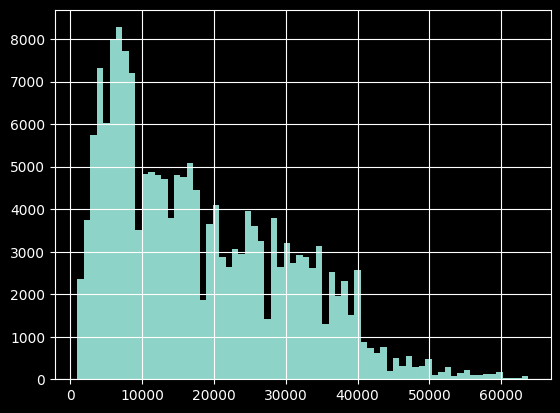

In [60]:
df['price'].hist(bins=70)
plt.show()

## Spatial Data

Unfortunetely, spatial interpolation is not scaleable to the number of observations in our dataset, and taking a subset of the data doesn't work well. Therefore, I used k-means clustering to create 100 geographic zones.

In [61]:
usa_gdf = read_file('data/us_data/cb_2018_us_nation_20m.shp')
usa_mp = usa_gdf['geometry'].values[0]

usa_bounds = Polygon([
    (-130, 23), (-130, 50),
    (-60, 50), (-60, 23)
])

continental_usa_mp = usa_mp.intersection(usa_bounds).geoms[-1]
continental_usa_gdf = GeoSeries(continental_usa_mp)

NameError: name 'read_file' is not defined

In [ ]:
scatter_kwargs = {'marker': 'o', 's': 2, 'cmap': 'coolwarm'}

ax = plt.gca()
continental_usa_gdf.plot(ax=ax, color='bisque')
ax.scatter(
    df['long'], 
    df['lat'],
    c=df['price'], 
    **scatter_kwargs
)
plt.show()

In [ ]:
k_means_coords = KMeans(n_clusters=100, random_state=11, n_init='auto')

df_cluster_train = pd.DataFrame({
    'long': train['long'], 
    'lat': train['lat'],
    'cluster': k_means_coords.fit_predict(X_train[['long', 'lat']])
})

In [ ]:
ax = plt.gca()
continental_usa_gdf.plot(ax=ax, color='bisque')
ax.scatter(
    df_cluster_train['long'],
    df_cluster_train['lat'],
    c=df_cluster_train['cluster'],
    cmap='tab20c',
    s=2,
    marker='o'
)
plt.show()

In [ ]:
X_train['cluster'] = df_cluster_train['cluster']
X_test['cluster'] = k_means_coords.predict(X_test[['long', 'lat']])

In [ ]:
#X_train.to_csv('data_clean/X_train.csv')
#X_test.to_csv('data_clean/X_test.csv')
#y_train.to_csv('data_clean/y_train.csv')
#y_test.to_csv('data_clean/y_test.csv')

## XGBoost

In [ ]:
xgb_X_train = pd.get_dummies(X_train, columns=factor_vars['all']+['cluster'])
xgb_X_test = pd.get_dummies(X_test, columns=factor_vars['all']+['cluster'])

xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    random_state=0,
    eval_metrics=mean_squared_error,
    verbosity=0
)

In [ ]:
%%time
xgb_reg.fit(xgb_X_train, y_train);

In [ ]:
xgb_reg_train_mae = mean_absolute_error(y_train, xgb_reg.predict(xgb_X_train))
xgb_reg_test_mae = mean_absolute_error(y_test, xgb_reg.predict(xgb_X_test))

print(xgb_reg_train_mae, xgb_reg_test_mae)

## GAM Utils

In [134]:
def plot_mileage_age_curves(gam: GAM):

    miles_pd_X = gam.generate_X_grid(term=0)[:, 0]
    age_pd_X = gam.generate_X_grid(term=1)[:, 1]

    miles_pd_log = gam.partial_dependence(term=0)
    age_pd_log = gam.partial_dependence(term=1)

    miles_pd_exp = np.exp(miles_pd_log)
    age_pd_exp = np.exp(age_pd_log)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].set_ylabel('Log Effect on Price')
    axs[0].set_xlabel('miles_10k / car_age_years')
    axs[0].plot(miles_pd_X, miles_pd_log, label='miles_10k')
    axs[0].plot(age_pd_X, age_pd_log, label='car_age_years')
    axs[0].legend()

    axs[1].set_ylabel('Multiplicative Effect on Price')
    axs[1].set_xlabel('miles_10k / car_age_years')
    axs[1].plot(miles_pd_X, miles_pd_exp, label='miles_10k')
    axs[1].plot(age_pd_X, age_pd_exp, label='car_age_years')
    axs[1].legend()
    
    plt.show()

In [141]:
# gam_1 = GammaGAM(gam_1_model).fit(X_train, y_train)
gam_1

GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + intercept,
   tol=0.0001, verbose=False)

In [146]:
gam_1.partial_dependence(term=0)

array([1.23321108, 1.2575278 , 1.27699796, 1.29191841, 1.30258604,
       1.30929772, 1.31235033, 1.31204074, 1.30866584, 1.30252248,
       1.29390756, 1.28311794, 1.27045051, 1.25620213, 1.24066968,
       1.22413051, 1.20674147, 1.18861347, 1.16985734, 1.15058391,
       1.13090401, 1.11092847, 1.0907681 , 1.07053375, 1.05033624,
       1.0302864 , 1.01049506, 0.99107304, 0.97213118, 0.95377037,
       0.93599399, 0.91875008, 0.90198603, 0.88564922, 0.86968706,
       0.85404694, 0.83867624, 0.82352236, 0.8085327 , 0.79365465,
       0.7788356 , 0.76402294, 0.74916407, 0.73421086, 0.71919049,
       0.70419261, 0.68930876, 0.6746305 , 0.66024936, 0.6462569 ,
       0.63274465, 0.61980417, 0.60752699, 0.59600467, 0.58532874,
       0.57559076, 0.56688227, 0.55929185, 0.55281033, 0.54731069,
       0.54265891, 0.53872098, 0.53536286, 0.53245054, 0.52984999,
       0.5274272 , 0.52504813, 0.52257877, 0.5198851 , 0.51683309,
       0.51328872, 0.50911912, 0.50429248, 0.49895496, 0.49327

In [150]:
miles_pd_log = gam_1.partial_dependence(term=0)
np.exp(miles_pd_log)

array([3.43223303, 3.51671672, 3.58585865, 3.63976242, 3.67879789,
       3.70357186, 3.71489469, 3.71374479, 3.70123237, 3.67856409,
       3.64700966, 3.60787134, 3.56245711, 3.51205778, 3.4579284 ,
       3.40120749, 3.34257501, 3.28252674, 3.22153303, 3.16003756,
       3.09845628, 3.037177  , 2.9765595 , 2.91693601, 2.85861215,
       2.80186818, 2.74696059, 2.69412383, 2.64357238, 2.59547713,
       2.54974662, 2.50615594, 2.4644928 , 2.42455796, 2.38616401,
       2.34913444, 2.31330269, 2.27851146, 2.24461206, 2.2114638 ,
       2.17893363, 2.1468957 , 2.11523109, 2.08383691, 2.0527708 ,
       2.02221331, 1.99233788, 1.9633074 , 1.93527486, 1.90838417,
       1.88277105, 1.85856404, 1.83588562, 1.81485335, 1.79558117,
       1.7781807 , 1.76276266, 1.7494332 , 1.73813088, 1.72859802,
       1.72057565, 1.71381345, 1.70806792, 1.70310072, 1.69867748,
       1.69456691, 1.69054022, 1.68637082, 1.6818344 , 1.67670924,
       1.67077688, 1.66382492, 1.65581358, 1.6469992 , 1.63766

In [164]:
gam_1.partial_dependence(term=1)

array([1.74643606, 1.69038226, 1.6396774 , 1.59382328, 1.55232166,
       1.51467434, 1.48038311, 1.44894975, 1.41987604, 1.39266377,
       1.36681473, 1.34183071, 1.31721348, 1.29246483, 1.26708655,
       1.2406425 , 1.2130796 , 1.18449076, 1.15496917, 1.12460804,
       1.09350055, 1.06173991, 1.02941931, 0.99663194, 0.963471  ,
       0.9300297 , 0.89640121, 0.86267875, 0.8289555 , 0.79532322,
       0.76185941, 0.72863353, 0.69571492, 0.66317293, 0.6310769 ,
       0.59949618, 0.56850012, 0.53815807, 0.50853938, 0.47971339,
       0.45174945, 0.42471691, 0.39868512, 0.37372266, 0.34988546,
       0.32721892, 0.3057681 , 0.2855781 , 0.26669398, 0.24916083,
       0.23302372, 0.21832774, 0.20511796, 0.19343946, 0.18333733,
       0.17485662, 0.16804244, 0.16293727, 0.15949843, 0.15758059,
       0.15703229, 0.15770208, 0.1594385 , 0.1620901 , 0.16550543,
       0.16953304, 0.17402148, 0.17881928, 0.183775  , 0.18873719,
       0.19355439, 0.19807572, 0.20219953, 0.20591095, 0.20920

In [148]:
gam_1.generate_X_grid(term=0)[:, 0]

array([ 0.        ,  0.4040404 ,  0.80808081,  1.21212121,  1.61616162,
        2.02020202,  2.42424242,  2.82828283,  3.23232323,  3.63636364,
        4.04040404,  4.44444444,  4.84848485,  5.25252525,  5.65656566,
        6.06060606,  6.46464646,  6.86868687,  7.27272727,  7.67676768,
        8.08080808,  8.48484848,  8.88888889,  9.29292929,  9.6969697 ,
       10.1010101 , 10.50505051, 10.90909091, 11.31313131, 11.71717172,
       12.12121212, 12.52525253, 12.92929293, 13.33333333, 13.73737374,
       14.14141414, 14.54545455, 14.94949495, 15.35353535, 15.75757576,
       16.16161616, 16.56565657, 16.96969697, 17.37373737, 17.77777778,
       18.18181818, 18.58585859, 18.98989899, 19.39393939, 19.7979798 ,
       20.2020202 , 20.60606061, 21.01010101, 21.41414141, 21.81818182,
       22.22222222, 22.62626263, 23.03030303, 23.43434343, 23.83838384,
       24.24242424, 24.64646465, 25.05050505, 25.45454545, 25.85858586,
       26.26262626, 26.66666667, 27.07070707, 27.47474747, 27.87

In [161]:
gam_1.generate_X_grid(term=0)[2]

array([0.80808081, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [172]:
X_grid = gam_1.generate_X_grid(term=0)
X_grid[:, 0] = 10
pd_value = gam_1.partial_dependence(term=0, X=X_grid)
pd_value[0]

1.0352789579907549

In [171]:
X_grid = gam_1.generate_X_grid(term=0)
pd_vals, pd_grid = gam_1.partial_dependence(term=0, X=X_grid)
specific_value_idx = np.where(pd_grid[:,0] == 10)[0][0]
specific_pd_value = pd_vals[specific_value_idx]
specific_pd_value

ValueError: too many values to unpack (expected 2)

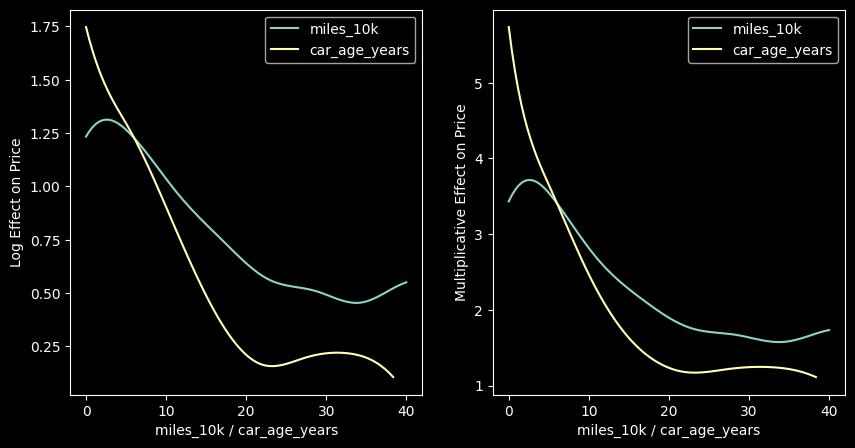

In [135]:
plot_mileage_age_curves(gam_1)

In [130]:
def gam_diagnostics_plot(gam: GAM, X_train: np.ndarray, y_train: np.ndarray):

    y_train_hat = gam.predict_mu(X_train)
    residuals = gam.deviance_residuals(X_train, y_train)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    # qq plot
    axs[0, 0].set_title('QQ')
    qqplot(residuals, ax=axs[0, 0], line='s')

    # residuals vs linear predictor
    axs[0, 1].set_title('residuals vs prediction')
    axs[0, 1].scatter(x=y_train_hat, y=residuals)
    axs[0, 1].set_xlabel('predicted value')
    axs[0, 1].set_ylabel('residual')

    # residuals histogram
    axs[1, 0].set_title('residuals histogram')
    axs[1, 0].hist(residuals, bins=75)
    axs[1, 0].set_xlabel('residual')
    axs[1, 0].set_ylabel('frequency')

    # observed vs fitted values
    axs[1, 1].set_title('observed vs fitted values')
    axs[1, 1].scatter(x=y_train, y=y_train_hat)
    axs[1, 1].set_xlabel('observed value')
    axs[1, 1].set_ylabel('fitted value')
    axs[1, 1].plot(np.arange(y_train.max()), color='red')

    plt.show()


In [131]:
def plot_predictions_histogram(y_train_hat: np.ndarray, y_test_hat: np.ndarray):

    fig, axs = plt.subplots(1, 2, figsize=(7, 5))
    fig.subplots_adjust(wspace=0.4)

    axs[0].hist(y_train_hat, bins=75)
    axs[0].set_xlabel('price')
    axs[0].set_ylabel('frequency')
    axs[0].set_title('training data')

    axs[1].hist(y_test_hat, bins=75)
    axs[1].set_xlabel('price')
    axs[1].set_ylabel('frequency')
    axs[1].set_title('testing data')
    plt.show()


In [132]:
def print_gam_summary_stats(gam: GAM):
    stats = gam.statistics_
    
    edof = stats['edof']
    aic = stats['AIC']
    aicc = stats['AICc']
    r2 = stats['pseudo_r2']['explained_deviance']
    gcv = stats['GCV']

    print(f'Effective degrees of freedom: {edof}')
    print(f'AIC: {aic}')
    print(f'AICc: {aicc}')
    print(f'Pseudo R^2: {r2}')
    print(f'GCV: {gcv}')


## Gamma GAM Regression

A GAM is a model of the form 
$$
g[u(Y|X)] = \sum_{i=1}^m f_i(X)
$$
where $\{f_i\}$ are smooth (continous or categorical) functions. $u(Y|X)$ is our prediction given some input - in this case, the predicted price of a car given its age, condition, etc. Each $f_i$ may only consider one variable, or it may consider an interaction of variables. With Gamma GAMS, $g(x):=log(x)$, so 
$$
u(Y|X) = e^{\sum_{i=1}^m f_i(X)} = e^{f_1(X)}e^{f_2(X)} \dots e^{f_m(X)} = \prod_{i=1}^m e^{f_i(X)}
$$

## GAM 1

All variables, no interactions, no geographic data

In [133]:
X_train

,miles_10k,car_age_years,condition,title_status,fuel,type,model,manufacturer,cylinders,drive,transmission,paint_color,long,lat
360663,18.9509,11.317808,0,2,2,6,156,6,6,2,0,9,-86.743824,36.107596
157259,3.9014,4.317808,0,0,2,0,145,24,2,2,0,6,-93.698520,41.600223
368802,12.7008,8.342466,0,0,2,8,19,6,5,3,0,0,-96.730124,32.958514
360686,1.0566,2.312329,2,0,4,6,0,27,4,2,2,0,-86.780000,36.170000
173677,6.8781,13.287671,0,0,2,7,29,31,2,1,0,10,-85.697708,38.159627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359491,3.4908,1.328767,0,0,2,7,17,24,6,1,0,10,-86.636868,36.302267
423056,2.8162,3.326027,2,0,2,7,11,2,6,2,2,6,-87.960000,43.060000
278902,5.1367,3.312329,2,0,2,6,30,10,4,0,2,6,-77.610000,43.160000
417200,10.6782,10.334247,0,0,2,0,171,10,2,0,0,5,-88.049143,44.610504


In [139]:
gam_1_model = s(0, n_splines=10, lam=0.6)
gam_1_model += s(1, n_splines=10, lam=0.6)

for var in factor_vars:
    gam_1_model += f(X_train.columns.get_loc(var))

gam_1_model

s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11)

In [140]:
# Grid search does not lead to significant improvement
t0 = time.time()
gam_1 = GammaGAM(gam_1_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam1 fit time: {t} seconds')

with open('gams_2/gam_1.pkl', 'wb') as f_gam:
    pickle.dump(gam_1, f_gam)

gam1 fit time: 33.177205085754395 seconds


In [86]:
with open('gams_2/gam_1.pkl', 'rb') as f_gam:
    gam_1 = pickle.load(f_gam)

In [87]:
gam_1_y_train_hat = gam_1.predict_mu(X_train)

In [84]:
X_train

,miles_10k,car_age_years,condition,title_status,fuel,type,model,manufacturer,cylinders,drive,transmission,paint_color,long,lat
360663,18.9509,11.317808,0,2,2,6,156,6,6,2,0,9,-86.743824,36.107596
157259,3.9014,4.317808,0,0,2,0,145,24,2,2,0,6,-93.698520,41.600223
368802,12.7008,8.342466,0,0,2,8,19,6,5,3,0,0,-96.730124,32.958514
360686,1.0566,2.312329,2,0,4,6,0,27,4,2,2,0,-86.780000,36.170000
173677,6.8781,13.287671,0,0,2,7,29,31,2,1,0,10,-85.697708,38.159627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359491,3.4908,1.328767,0,0,2,7,17,24,6,1,0,10,-86.636868,36.302267
423056,2.8162,3.326027,2,0,2,7,11,2,6,2,2,6,-87.960000,43.060000
278902,5.1367,3.312329,2,0,2,6,30,10,4,0,2,6,-77.610000,43.160000
417200,10.6782,10.334247,0,0,2,0,171,10,2,0,0,5,-88.049143,44.610504


In [91]:
gam_1_y_train_hat = gam_1.predict_mu(X_train)
gam_1_train_mae = mean_absolute_error(y_train, gam_1_y_train_hat)

gam_1_y_test_hat = gam_1.predict_mu(X_test)
gam_1_test_mae = mean_absolute_error(y_test, gam_1_y_test_hat)

print(f'gam1 train set mean absolute error: {gam_1_train_mae}')
print(f'gam1 test set mean absolute error: {gam_1_test_mae}')

gam1 train set mean absolute error: 3127.8338598264613
gam1 test set mean absolute error: 3139.1438697935546


In [42]:
print_gam_summary_stats(gam_1)

Effective degrees of freedom: 251.70380474891945
AIC: 2781483.6461482258
AICc: 2781484.543607299
Pseudo R^2: 0.8509319256718683
GCV: 0.08327957516297436


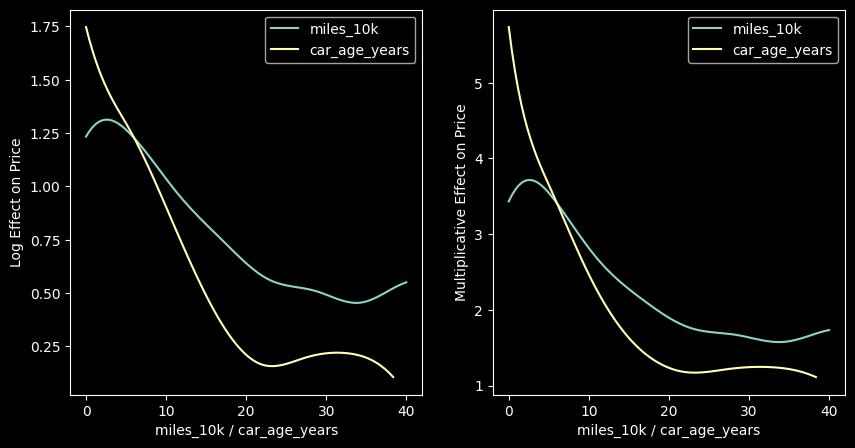

In [151]:
plot_mileage_age_curves(gam_1)

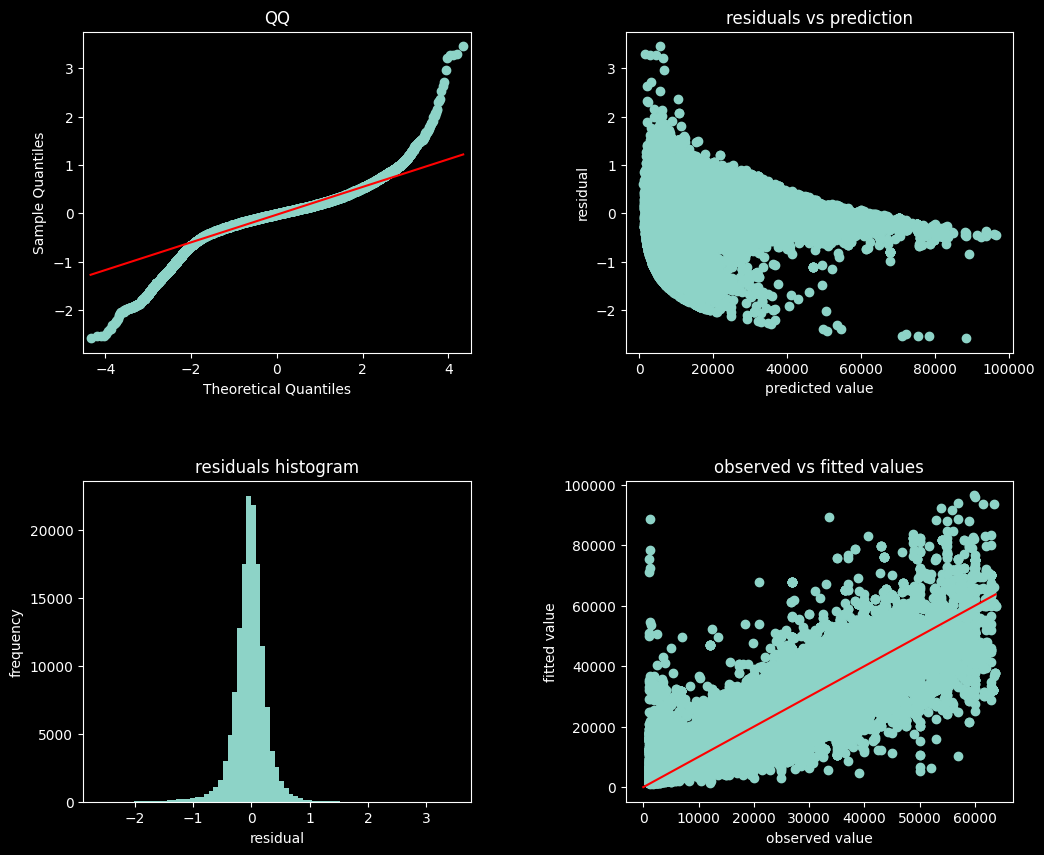

In [152]:
gam_diagnostics_plot(gam_1, X_train, y_train)

## GAM 2

All variables, interaction between mileage, age, condition and manufacturer

In [34]:
# Splines
gam_2_model = s(0, n_splines=10, lam=0.6) 
gam_2_model += s(1, n_splines=10, lam=0.6)

# Factors
for var in factor_vars:
    idx = X_train.columns.get_loc(var)
    gam_2_model += f(idx)

# Interactions
gam_2_model += te(s(0, n_splines=10, lam=0.6), f(7)) # miles*manufacturer
gam_2_model += te(s(1, n_splines=10, lam=0.6), f(7)) # age*manufacturer
gam_2_model += te(f(2), f(7))                        # condition*manufacturer

gam_2_model

s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + te(0, 7) + te(1, 7) + te(2, 7)

In [35]:
t0 = time.time()
gam_2 = GammaGAM(gam_2_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam2 training time: {t} seconds')

with open('gams_2/gam_2.pkl', 'wb') as f_gam:
    pickle.dump(gam_2, f_gam)

KeyboardInterrupt: 

In [37]:
with open('gams_2/gam_2.pkl', 'rb') as f_gam:
    gam_2 = pickle.load(f_gam)

In [38]:
gam_2_y_train_hat = gam_2.predict_mu(X_train)
gam_2_train_mae = mean_absolute_error(y_train, gam_2_y_train_hat)

gam_2_y_test_hat = gam_2.predict_mu(X_test)
gam_2_test_mae = mean_absolute_error(y_test, gam_2_y_test_hat)

print(f'gam2 train set mean absolute error: {gam_2_train_mae}')
print(f'gam2 test set mean absolute error: {gam_2_test_mae}')

ValueError: X data must have 15 features, but found 14

In [40]:
print_gam_summary_stats(gam_2)

Effective degrees of freedom: 655.1339654843606
AIC: 2773108.6247911095
AICc: 2773114.676276302
Pseudo R^2: 0.8605846047785473
GCV: 0.07844039953430221


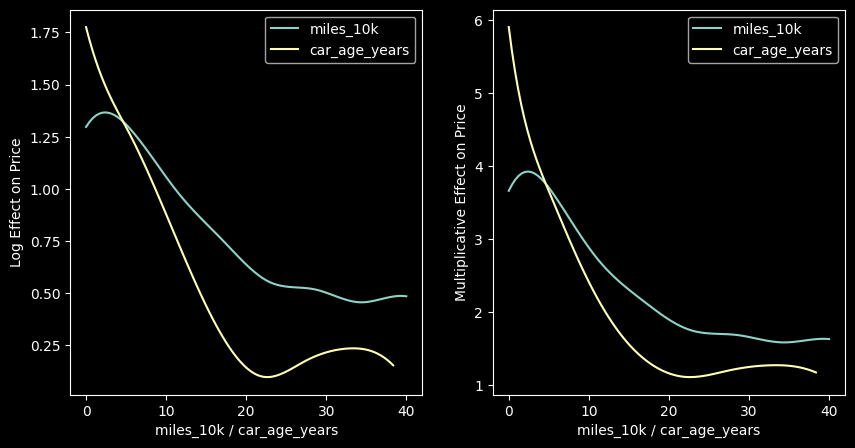

In [35]:
plot_mileage_age_curves(gam_2)

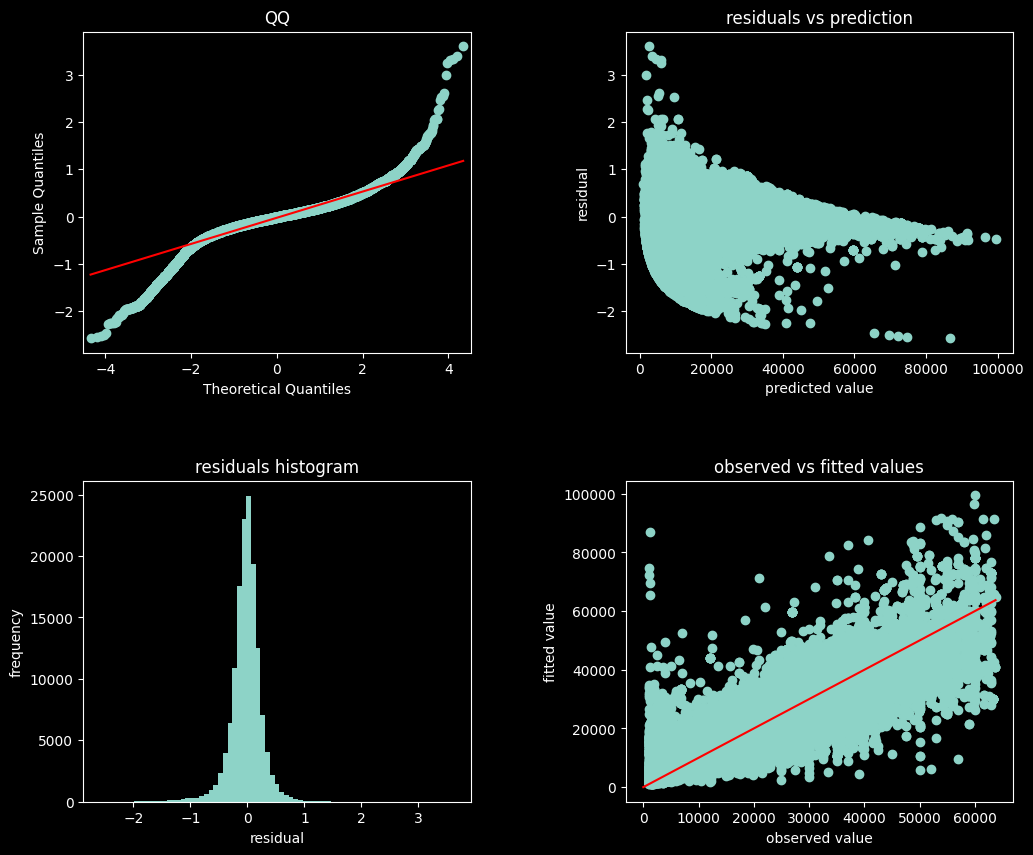

In [42]:
gam_diagnostics_plot(gam_2, X_train, y_train)

## GAM 3
All variables, interactions between mileage, age, condition and manufacturer, geographic zones

In [39]:
# Splines
gam_3_model = s(0, n_splines=10, lam=0.6) 
gam_3_model += s(1, n_splines=10, lam=0.6)

# Factors
for var in factor_vars + ['cluster']:
    idx = X_train.columns.get_loc(var)
    gam_3_model += f(idx)

# Interactions
gam_3_model += te(s(0, n_splines=10), f(7)) #miles*manufacturer
gam_3_model += te(s(1, n_splines=10), f(7)) #age*manufacturer
gam_3_model += te(f(2), f(7)) #condition*manufacturer

gam_3_model

KeyError: 'cluster'

In [ ]:
t0 = time.time()
gam_3 = GammaGAM(gam_3_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam3 training time: {t} seconds')

with open('gams/gam_3.pkl', 'wb') as f_gam:
    pickle.dump(gam_3, f_gam)

In [36]:
with open('gams/gam_3.pkl', 'rb') as f_gam:
    gam_3 = pickle.load(f_gam)

In [42]:
gam_3_y_train_hat = gam_3.predict(X_train)
gam_3_train_mae = mean_absolute_error(y_train, gam_3_y_train_hat)

gam_3_y_test_hat = gam_3.predict(X_test)
gam_3_test_mae = mean_absolute_error(y_test, gam_3_y_test_hat)

print(f'gam3 train set mean absolute error: {gam_3_train_mae}')
print(f'gam3 test set mean absolute error: {gam_3_test_mae}')

gam3 train set mean absolute error: 2879.1559496227687
gam3 test set mean absolute error: 2898.4038229258754


In [43]:
print_gam_summary_stats(gam_3)

Effective degrees of freedom: 753.9971625063325
AIC: 2768668.3185923942
AICc: 2768676.335048756
Pseudo R^2: 0.864934121120585
GCV: 0.07614130501462736


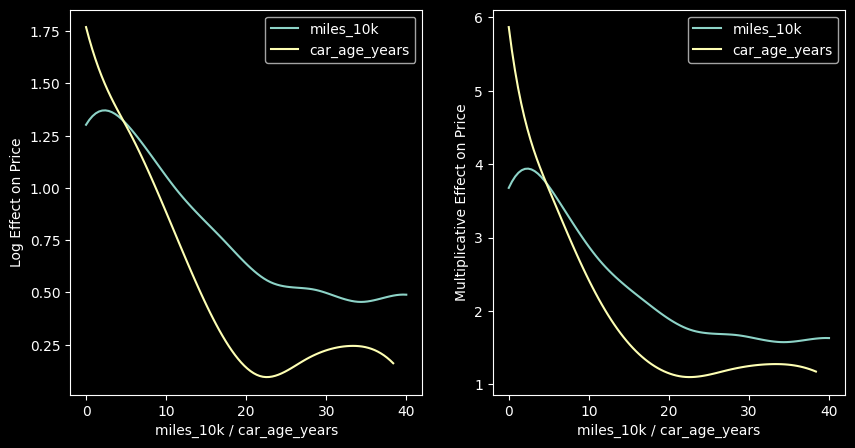

In [44]:
plot_mileage_age_curves(gam_3)

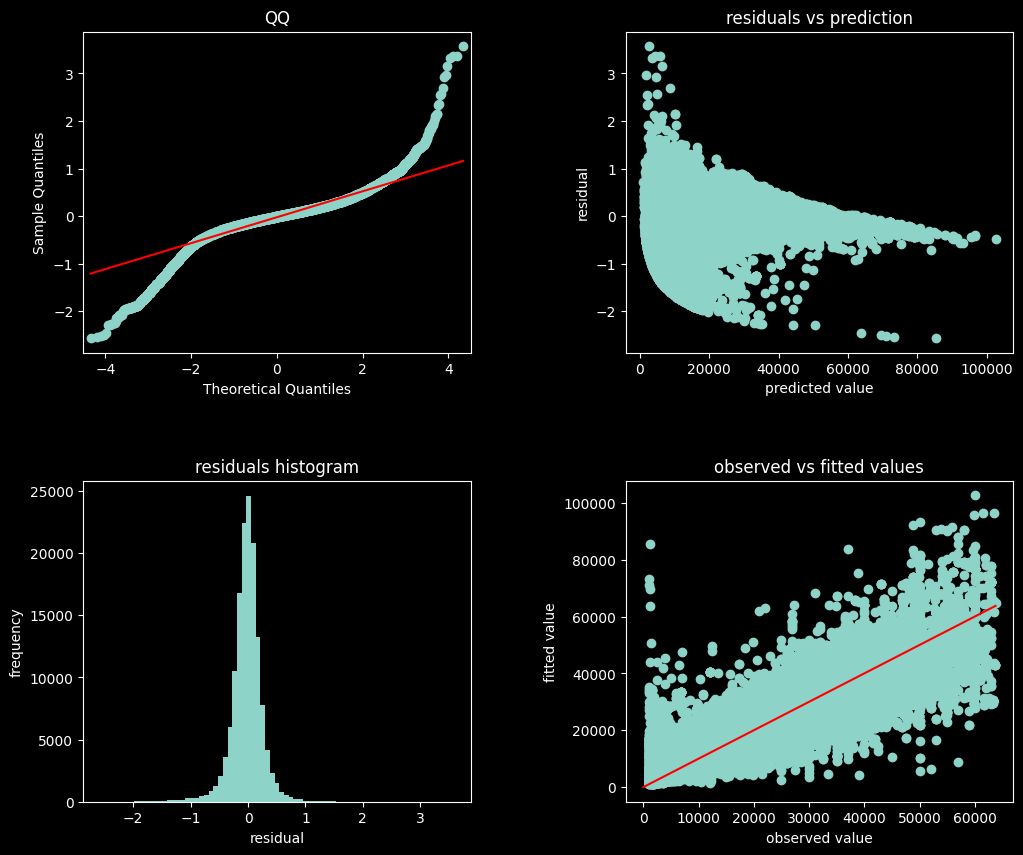

In [45]:
gam_diagnostics_plot(gam_3, X_train, y_train)

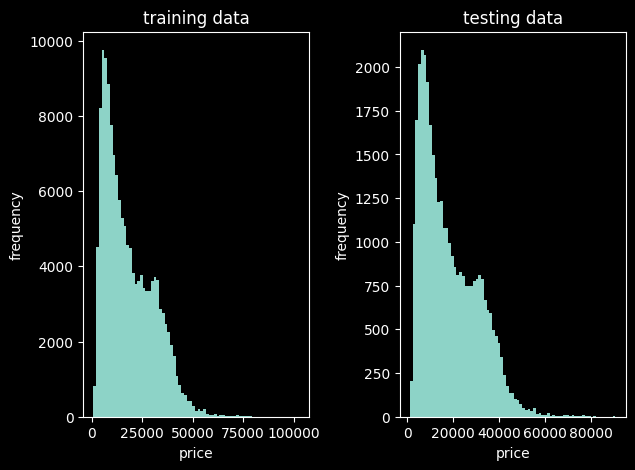

In [50]:
plot_predictions_histogram(gam_3_y_train_hat, gam_3_y_test_hat)

## GAM 4

In [40]:
# Splines
gam_4_model = s(0, n_splines=10, lam=0.6) 
gam_4_model += s(1, n_splines=10, lam=0.6)
gam_4_model += te(s(0, n_splines=10), s(1, n_splines=10)) #miles*age

# Factors
for var in factor_vars + ['cluster']:
    idx = X_train.columns.get_loc(var)
    gam_4_model += f(idx)

# Interactions
gam_4_model += te(s(0, n_splines=10), f(7)) #miles*manufacturer
gam_4_model += te(s(1, n_splines=10), f(7)) #age*manufacturer
gam_4_model += te(f(2), f(7)) #condition*manufacturer

gam_4_model

KeyError: 'cluster'

In [ ]:
t0 = time.time()
gam_4 = GammaGAM(gam_4_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam4 training time: {t} seconds')

with open('gams/gam_4.pkl', 'wb') as f_gam:
    pickle.dump(gam_4, f_gam)

In [51]:
with open('gams/gam_4.pkl', 'rb') as f_gam:
    gam_4 = pickle.load(f_gam)

In [52]:
gam_4_y_train_hat = gam_4.predict(X_train)
gam_4_train_mae = mean_absolute_error(y_train, gam_4_y_train_hat)

gam_4_y_test_hat = gam_4.predict(X_test)
gam_4_test_mae = mean_absolute_error(y_test, gam_4_y_test_hat)

print(f'gam4 train set mean absolute error: {gam_4_train_mae}')
print(f'gam4 test set mean absolute error: {gam_4_test_mae}')

gam4 train set mean absolute error: 2839.8921744250597
gam4 test set mean absolute error: 2860.260522359181


In [53]:
print_gam_summary_stats(gam_4)

Effective degrees of freedom: 782.5555757947934
AIC: 2766045.42797582
AICc: 2766054.063676337
Pseudo R^2: 0.8673919515066311
GCV: 0.07479782550670028


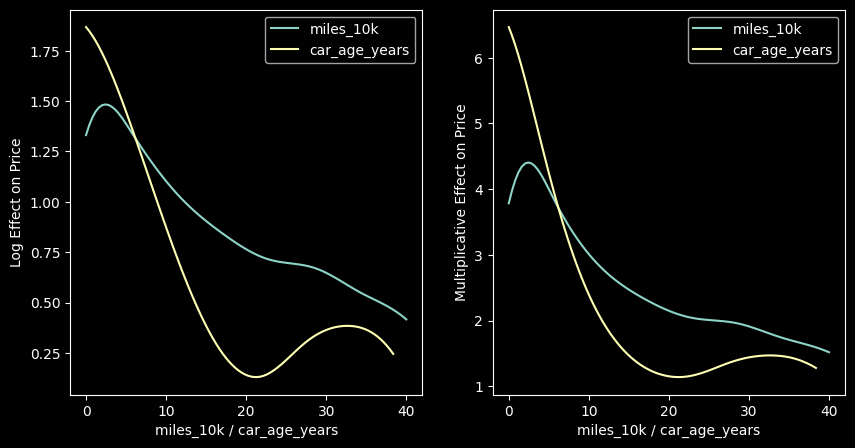

In [54]:
plot_mileage_age_curves(gam_4)

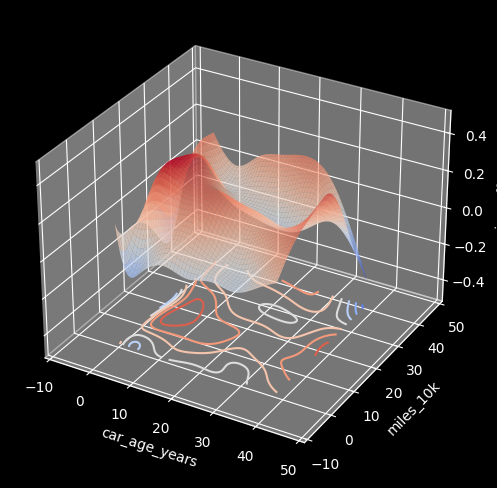

In [55]:
Y, X = gam_4.generate_X_grid(term=2, meshgrid=True)
Z = gam_4.partial_dependence(term=2, X=(X, Y), meshgrid=True)

ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')

ax.set(
    xlim=(-10, 50), ylim=(-10, 50), zlim=(-0.5, 0.5), 
    xlabel='car_age_years', ylabel='miles_10k', zlabel='price_effect'
)

ax.plot_surface(X, Y, Z, alpha=0.75, cmap='coolwarm')
ax.contour(X, Y, Z, zdir='z', offset=-0.5, alpha=1, cmap='coolwarm')

plt.show()